# Duffing Oscillator Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the Duffing oscillator system.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Duffing Oscillator                                                                                                                                                                                                                             |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | All eigenpairs with feasible residuals                                                                                                                                                                                                         |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |


In [1]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/home/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


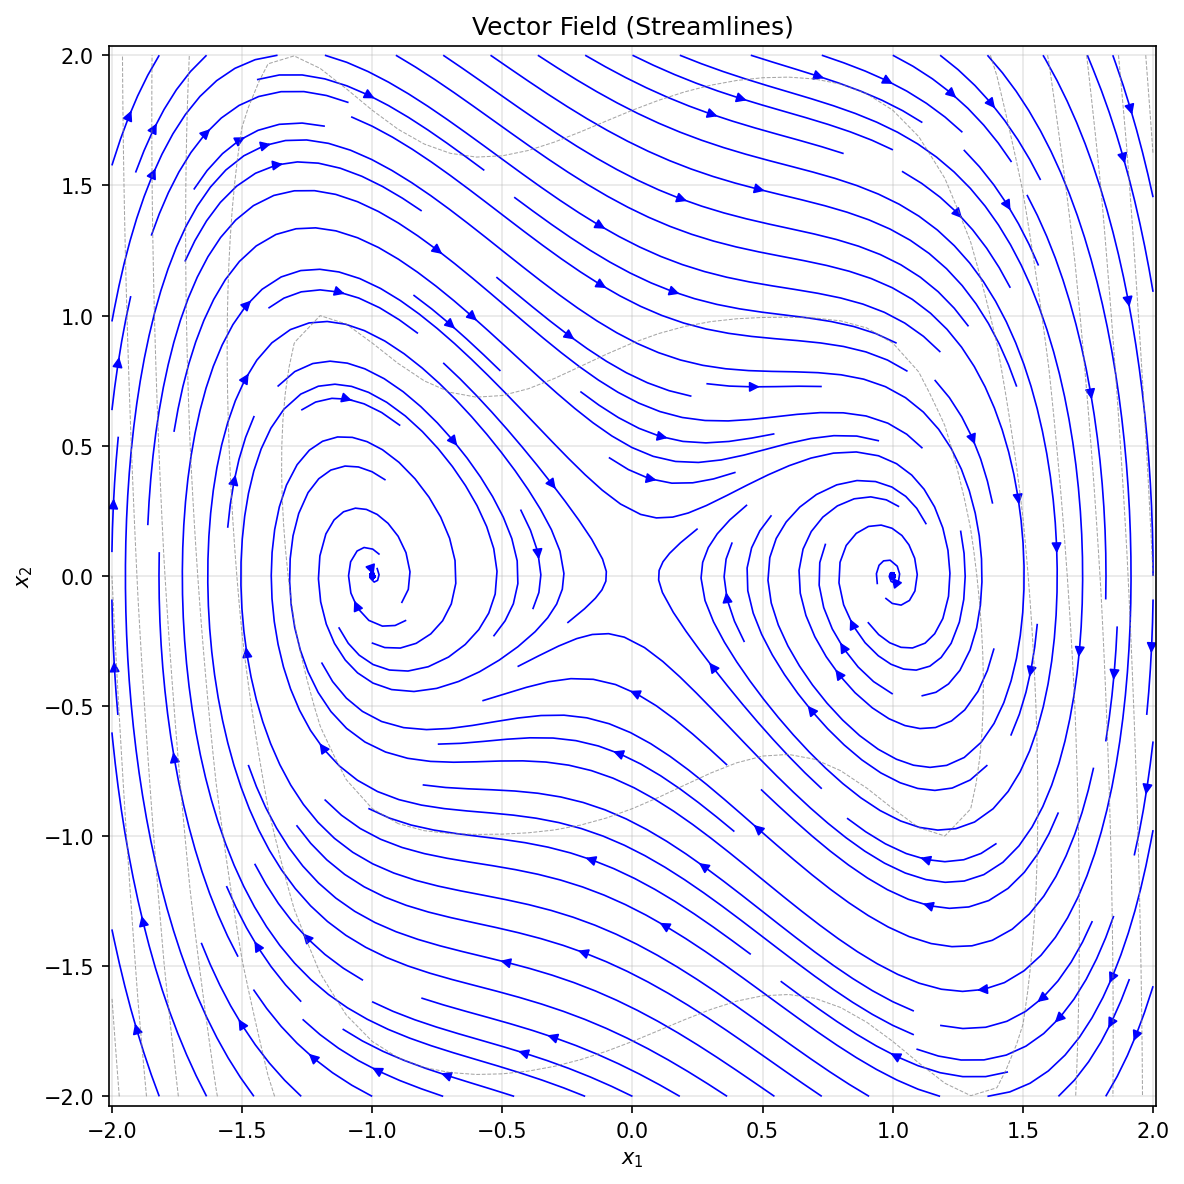

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [2]:
# define the dynamical system
duffing_oscillator = ddrv.dynamic.DuffingOscillator()
ddrv.viz.vis_vector_field_2d(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 10 steps, 0.05 time step...
(11, 1000, 2)


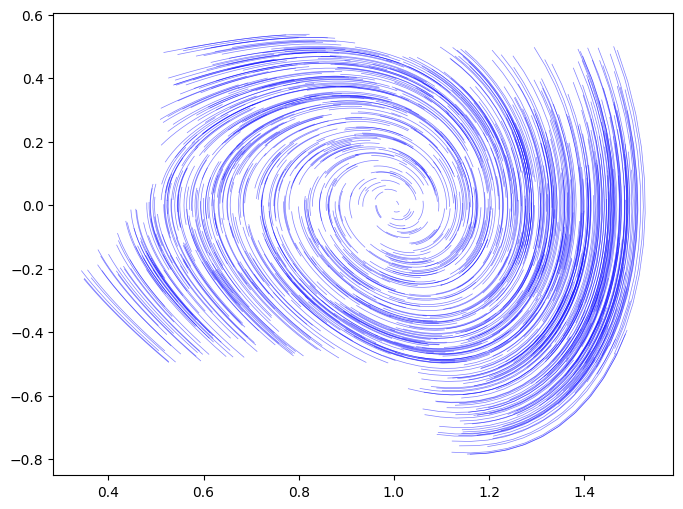

In [3]:
# set the seed for reproducibility
np.random.seed(42)

DELTA_T = 0.05

# generate the trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    duffing_oscillator,
    domain=[[0.5, 1.5], [-0.5, 0.5]],
    num_samples=1000,
    num_steps=10,
    delta_t=0.05,
)
print(traj_data.shape)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)

In [4]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(10000, 2) (10000, 2)


In [14]:
# apply the resdmd algorithm


LAM, V, residuals, observables, PX, PY, K = ddrv.algo.resdmd(
    X, Y, observe_params={"basis": "poly", "degree": 9}
)

print(
    LAM.shape,
    V.shape,
    residuals.shape,
    observables.shape,
    PX.shape,
    PY.shape,
    K.shape,
)

threshold = 1e-3  # threshold of residuals for selecting the feasible eigenpairs
# get the eigenvalues and eigenvectors with residuals less than the threshold
idx_candidates = np.where(residuals < threshold)[0]
# sort the indices by residuals from smallest to largest
idx = idx_candidates[np.argsort(residuals[idx_candidates])]
print(idx, "idx")

LAM_feasible_dt = LAM[idx]  #  these are discrete eigenvalues
# get the continuous eigenvalues
LAM_feasible_ct = np.log(LAM_feasible_dt) / DELTA_T
V_feasible = V[:, idx].T
print(LAM_feasible_dt.shape, V_feasible.shape)
print(LAM_feasible_ct, "LAM_feasible_ct")

PX.shape, V.shape (10000, 55) (55, 55)
(55,) (55, 55) (55,) (2, 55) (10000, 55) (10000, 55) (55, 55)
[39 50 38 37 44 45 48 49 42 43 25 26 31 32 51 52] idx
(16,) (16, 55)
[ 8.88178420e-14+0.j         -4.50013573e-01+0.j
 -1.84963402e+00-2.08551416j -1.84963402e+00+2.08551416j
 -1.70346172e+00+0.51228529j -1.70346172e+00-0.51228529j
 -2.35743530e-01+1.36635136j -2.35743530e-01-1.36635136j
 -8.35230588e-01+2.3355244j  -8.35230588e-01-2.3355244j
 -2.30542689e+00+4.46931621j -2.30542689e+00-4.46931621j
 -2.02987595e+00+3.27807973j -2.02987595e+00-3.27807973j
 -8.20300564e-01+0.52511414j -8.20300564e-01-0.52511414j] LAM_feasible_ct


In [16]:
# apply the reachability verification algorithm

# define the initial set, and target set for reachability verification
X0 = [[-0.8, -0.7], [1.8, 1.9]]
XF = [[0.6, 0.7], [0.2, 0.3]]

pts_X0 = ddrv.common.sample_box_set(X0, 5000)
pts_XF = ddrv.common.sample_box_set(XF, 5000)
print(pts_X0.shape, pts_XF.shape)

# evaluate the eigenfunctions on the initial set and target set samples
ef0_vals = observables.eval_mod(pts_X0, V_feasible)
efF_vals = observables.eval_mod(pts_XF, V_feasible)
print(ef0_vals.shape, efF_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(
    ef0_vals, efF_vals, LAM_feasible_ct
)
print(time_bounds, status, "time_bounds & status")

time_bounds = []

ddrv.viz.vis_rv(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    bounds=time_bounds,
    dt=0.01,
    initial_set=X0,
    target_set=XF,
)

(5000, 2) (5000, 2)
(5000, 16) (5000, 16)
[-inf,inf] bound_mag


KeyboardInterrupt: 